# Thông tin chung
Notebook này trình bày phần công việc của:
* Họ tên: Mai Duy Nam
* MSSV: 19120298

## Bảng phân công công việc

| STT | Công việc | Người thực hiện | MSSV |
| :--- | :--------- | :--------------- | :---- |
| **1** | **Phân tích dữ liệu user** | **Mai Duy Nam** | **19120298** |
| 2 | Phân tích dữ liệu track | Nguyễn Hữu Bình | 19120460 |
| 3 | Phân tích dữ liệu playlist | Lê Đức Huy | 19120080 |

---

# Nội dung phân tích dữ liệu

## Import các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 6)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.large_repr', 'truncate')

## Tổng quan về dữ liệu
Tập dữ liệu `user.csv` chứa 2000 record về thông tin người dùng của SoundCloud. Dữ liệu này được thu thập bằng cách:
* Crawl trên API cung cấp bởi SoundCloud
* Sử dụng thuật toán breadth-first search:
    * Gốc xuất phát là một người dùng xác định ([Artix](https://soundcloud.com/realartixmusic))
    * Thuật toán khám phá người dùng mới dựa trên hai mối quan hệ follower và following, trong đó 50% dữ liệu thu thập dùng quan hệ follower, 50% dùng quan hệ following

### Lưu ý về dữ liệu
Do tính chất của quá trình khám phá, các số liệu thu thập được phụ thuộc rất lớn vào người dùng được sử dụng ở đầu vào. Lý do em chọn Artix làm người dùng đầu vào là vì:
* Bạn ấy là người quen!
* Artix là một DJ không quá nhỏ cũng không quá lớn (số người theo dõi khoảng 2000 người)
* Artix cũng có một số bản nhạc gây được tiếng tăm đến cộng đồng nước ngoài chứ không chỉ gói gọn ở Việt Nam, do đó khám phá từ bạn ấy có thể mở rộng được đến nhiều quốc gia hơn

Như vậy, hạn chế của tập dữ liệu này nằm ở việc:
* Nó không khái quát được về người dùng nói chung của SoundCloud
* Có khả năng bị nhiễu lớn

### Những điều mong đợi từ dữ liệu
Với tính chất của dữ liệu trên, em có một số những dự đoán về dữ liệu như sau:
* Dữ liệu sẽ có độ phân tán lớn
* Dữ liệu có phân phối lệch về phía giá trị nhỏ
* Số người theo dõi trung bình sẽ cao do ta chạm đến được nhiều nghệ sĩ hơn
* Số các quốc gia sẽ cao

Theo đó, em sẽ đi tìm hiểu:
* Mối quan hệ giữa số track và số follower của user để xem liệu một nghệ sĩ sản xuất ra càng nhiều bài nhạc có giúp tăng số lượt theo dõi hay không

## Load dữ liệu và tiền xử lý

In [2]:
user_df = pd.read_csv('Api_data/user.csv', index_col=0, usecols=list(range(1, 15)))
user_df

,permalink_url,username,full_name,...,playlist_count,likes_count,comments_count
id,,,,,,,
682450937,https://soundcloud.com/luk...,SkAfFaBruUR,Luka Dbs,...,9,3654,13
1038569842,https://soundcloud.com/ann...,annajoe 💋💋,Anna Campbell,...,0,40,0
264386839,https://soundcloud.com/ali...,AliciaJade,AliciaJade Foy,...,1,329,0
191935148,https://soundcloud.com/lew...,LEWIS CHAPMAN,Lewis Chapman,...,5,657,4
522587076,https://soundcloud.com/mar...,Mary B Beresford 💛,Mary Beresford,...,0,1041,2
...,...,...,...,...,...,...,...
24415444,https://soundcloud.com/liv...,Liveon,NaN,...,0,139,74
311781492,https://soundcloud.com/evo...,Evolution Chamber,NaN,...,3,6,0
3494687,https://soundcloud.com/djl...,DJ Lucky Rabbit,Kriss Erickson,...,0,80,90


In [3]:
user_df.columns

Index(['permalink_url', 'username', 'full_name', 'city', 'country_code',
       'description', 'verified', 'followers_count', 'followings_count',
       'track_count', 'playlist_count', 'likes_count', 'comments_count'],
      dtype='object')

### Ý nghĩa các cột

Theo [SoundCloud Public API Specification](https://developers.soundcloud.com/docs/api/explorer/open-api):
* `permalink_url`: Đường dẫn đến trang cá nhân của user
* `username`
* `full_name`: Tên đầy đủ của user
* `country_code`: Mã quốc gia (2 ký tự)
* `description`: Thông tin mô tả về user
* `followers_count`: Tổng số người theo dõi user
* `followings_count`: Tổng số người mà user theo dõi
* `track_count`: Tổng số track được public
* `playlist_count`: Tổng số playlist được public
* `likes_count`: Tổng số track user đã thích
* `comments_count`: Tổng số lượt bình luận của user

### Danh sách kiểm tra phân tích dữ liệu
Ta cần tổng kết được các điều sau:
* Dữ liệu có bao nhiêu hàng, bao nhiêu cột?
* Các cột đã có kiểu dữ liệu phù hợp chưa?
* Các hàng có bị trùng nhau không?
    * Có người dùng nào bị lặp lại với các số liệu khác nhau không?
* Các cột giá trị số có phân bố như thế nào?
* Các cột kiểu giá trị category có tính chất như thế nào?
    * Có bao nhiêu giá trị thiếu?
    * Có bao nhiêu giá trị duy nhất?

#### Dữ liệu có bao nhiêu hàng, bao nhiêu cột?

In [4]:
num_rows, num_columns = user_df.shape
print(f'Number of rows: {num_rows}\nNumber of columns: {num_columns}')

Number of rows: 2000
Number of columns: 13


#### Các cột đã có kiểu dữ liệu phù hợp chưa?

In [5]:
user_df.dtypes

permalink_url       object
username            object
full_name           object
city                object
country_code        object
description         object
verified              bool
followers_count      int64
followings_count     int64
track_count          int64
playlist_count       int64
likes_count          int64
comments_count       int64
dtype: object

Như vậy, các cột đều đã có kiểu dữ liệu phù hợp:
* Các cột `permalink_url` đến `description` là dữ liệu categorical, tương ứng với kiểu `object`
* Cột `verified` cho biết user có được xác thực chưa, tương ứng với kiểu `bool`
* Các cột `followers_count` đến `comments_count` là dữ liệu dạng số nguyên, tương ứng với kiểu `int64`

#### Dữ liệu có bị trùng không?

Kiểm tra có hàng nào bị trùng không

In [6]:
user_df[user_df.duplicated()].size

0

Có user nào xuất hiện nhiều lần với các số liệu khác nhau không.

In [7]:
user_df[user_df.duplicated(subset='permalink_url', keep=False)]

,permalink_url,username,full_name,...,playlist_count,likes_count,comments_count
id,,,,,,,
2656381,https://soundcloud.com/ska...,Skankandbass,NaN,...,101,3698,849
2656381,https://soundcloud.com/ska...,Skankandbass,NaN,...,101,3698,849


Như vậy, có duy nhật một user bị lặp lại với số liệu khác nhau. Do sự sai khác rất nhỏ (chỉ chênh lệch 1 trong cột `followers_count`), em quyết định loại bỏ một trong hai user này.

In [8]:
user_df.drop_duplicates(subset='permalink_url', keep='first', inplace=True)
user_df.shape

(1999, 13)

#### Các dữ liệu dạng số được phân bố như thế nào

In [9]:
numerical_columns = ['followers_count', 'followings_count', 'track_count', 'playlist_count', 'likes_count', 'comments_count']
categorical_columns = ['permalink_url', 'username', 'full_name', 'city', 'country_code', 'description', 'verified']

In [10]:
user_df[numerical_columns].describe()

,followers_count,followings_count,track_count,playlist_count,likes_count,comments_count
count,"1,999.00","1,999.00","1,999.00","1,999.00","1,999.00","1,999.00"
mean,"21,653.89",446.52,54.68,8.02,905.12,215.64
std,"305,404.97",540.51,241.50,41.44,"2,738.12",837.36
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,48.00,41.50,1.00,0.00,23.00,2.00
50%,411.00,206.00,9.00,1.00,146.00,21.00
75%,"3,050.00",685.00,33.00,4.00,723.00,137.50
max,"8,319,039.00","2,014.00","6,645.00","1,210.00","77,573.00","25,806.00"


Giống như dự đoán, dữ liệu dạng số có:
* Độ phân tán lớn
* Bị lệch về phía giá trị nhỏ hơn (trung vị nhỏ hơn so với trung bình)
* Số người theo dõi tương đối cao (giá trị trung vị là 411)

#### Các dữ liệu dạng categorical được phân bố như thế nào

In [11]:
def compute_stats(col):
    return [col.unique().size, col.isna().sum() / col.size]
categorical_info = user_df[categorical_columns].apply(compute_stats)
categorical_info.index = ['num_values', 'missing_percentage']
categorical_info

,permalink_url,username,full_name,...,country_code,description,verified
num_values,"1,999.00","1,998.00","1,126.00",...,88.00,"1,370.00",2.00
missing_percentage,0.00,0.00,0.42,...,0.44,0.31,0.00


Như dự đoán, ta thu thập được user đến từ 88/195 = 45% số quốc gia trên thế giới. Ta có thể sẽ còn thu thập được nhiều hơn do có khá nhiều user có thông tin về thành phố nhưng không có thông tin về quốc gia.

In [12]:
user_df[(~user_df.city.isna()) & (user_df.country_code.isna())].shape

(263, 13)

## Phân tích và trực quan hóa

Ở phần này, ta chỉ quan tâm đến dữ liệu dạng số. Do đó, ta tạm thời bỏ qua các dạng dữ liệu khác.

In [13]:
numeric_values = user_df[numerical_columns].copy()

### Loại bỏ outlier
Ta thực hiện loại bỏ các giá trị không nằm trong khoảng $[Q_1 - 1.5 \cdot IQR, Q_3 + 1.5 \cdot IQR]$ trên từng cột, với $Q_1$, $Q_3$ là phân vị thứ 25 và 75 của cột, $IQR = Q_3 - Q_1$

In [14]:
q1 = numeric_values.quantile(0.25)
q3 = numeric_values.quantile(0.75)
iqr = q3 - q1

l, u = q1 - 1.5 * iqr, q3 + 1.5 * iqr

numeric_values, l = numeric_values.align(l, axis=1)
numeric_values = numeric_values[~((numeric_values < l) | (numeric_values > u)).any(axis=1)]
numeric_values

,followers_count,followings_count,track_count,playlist_count,likes_count,comments_count
id,,,,,,
1038569842,11,102,0,0,40,0
264386839,17,107,0,1,329,0
191935148,154,417,11,5,657,4
522587076,26,64,0,0,1041,2
931073569,8,4,0,0,223,0
...,...,...,...,...,...,...
181632094,1133,307,15,4,184,226
24415444,798,179,4,0,139,74
311781492,594,6,7,3,6,0


### Phân tích
Ta khảo sát mối tương quan giữa hai biến: `track_count` -  số bài nhạc người dùng đã chia sẻ và `followers_count` - số người theo dõi. Ta sẽ xem liệu một nghệ sĩ sáng tác nhiều bài hát hơn có giúp họ được chú ý hơn.

Trước tiên, ta xem xét sự phân bố của hai biến.

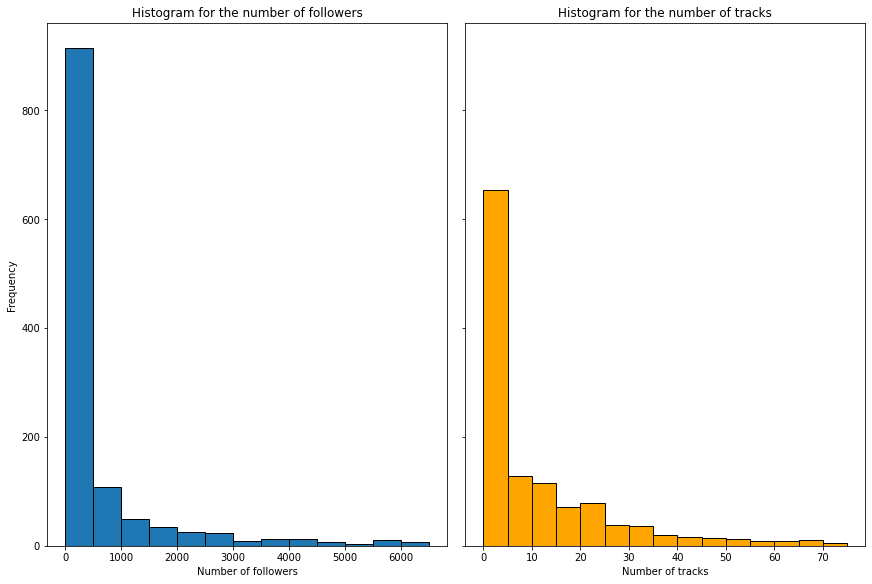

In [15]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)
ax1, ax2 = ax

ax1.hist(numeric_values.followers_count, edgecolor='black', bins=np.arange(0, 7000, 500))
ax2.hist(numeric_values.track_count, edgecolor='black', color='orange', bins=np.arange(0, 80, 5))

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Number of followers')
ax2.set_xlabel('Number of tracks')
ax1.set_title('Histogram for the number of followers')
ax2.set_title('Histogram for the number of tracks')

fig.set_size_inches(12, 8)
plt.show()

Scatter plot của hai biến

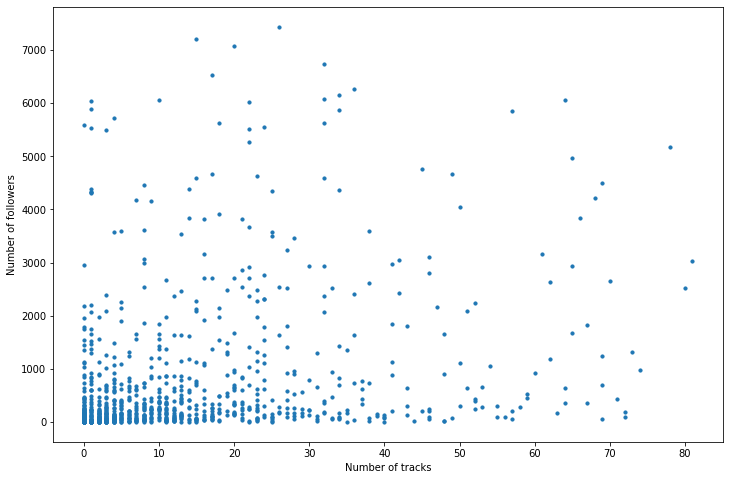

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(numeric_values.track_count, numeric_values.followers_count, s=10)
plt.xlabel('Number of tracks')
plt.ylabel('Number of followers')
plt.show()

Như vậy không có mối quan hệ đáng kể nào giữa số track và số follower, mặc dù về tổng thể vẫn có tương quan thuận giữa hai biến này, thể hiện qua hệ số tương quan:

In [17]:
np.corrcoef(numeric_values.track_count, numeric_values.followers_count)[0, 1]

0.3671988095837619

---

# Tham khảo

1. [SoundCloud Public API Specification](https://developers.soundcloud.com/docs/api/explorer/open-api)
2. [NumPy Documentation](https://numpy.org/doc/)
3. [pandas documentation](https://pandas.pydata.org/docs/)